## Arm Reaching (RM Session 1)

In [1]:
import os
import glob
import numpy as np
import mne
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from google.colab import drive
# drive.mount('/content/drive')
from scipy.io import loadmat
from scipy.signal import butter, lfilter
warnings.filterwarnings('ignore')

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [2]:
folder = r'converted data'
files = os.listdir(folder)
files

['Session_1_RM_Sub_10_arm_reaching_classes.fif',
 'Session_1_RM_Sub_10_rest_class.fif',
 'Session_1_RM_Sub_1_arm_reaching_classes.fif',
 'Session_1_RM_Sub_1_rest_class.fif',
 'Session_1_RM_Sub_2_arm_reaching_classes.fif',
 'Session_1_RM_Sub_2_rest_class.fif',
 'Session_1_RM_Sub_3_arm_reaching_classes.fif',
 'Session_1_RM_Sub_3_rest_class.fif',
 'Session_1_RM_Sub_4_arm_reaching_classes.fif',
 'Session_1_RM_Sub_4_rest_class.fif',
 'Session_1_RM_Sub_5_arm_reaching_classes.fif',
 'Session_1_RM_Sub_5_rest_class.fif',
 'Session_1_RM_Sub_6_arm_reaching_classes.fif',
 'Session_1_RM_Sub_6_rest_class.fif',
 'Session_1_RM_Sub_7_arm_reaching_classes.fif',
 'Session_1_RM_Sub_7_rest_class.fif',
 'Session_1_RM_Sub_8_arm_reaching_classes.fif',
 'Session_1_RM_Sub_8_rest_class.fif',
 'Session_1_RM_Sub_9_arm_reaching_classes.fif',
 'Session_1_RM_Sub_9_rest_class.fif']

In [3]:
decode = {11: 0, 21: 1, 31: 2, 41:3, 51: 4, 61: 5, 8 :6}
labels = []

data = []
for file in files:
    # if file.__contains__('rest_class'):
    #     continue

    epochs = mne.read_epochs(os.path.join(folder,file))
    epochs.pick_types(eeg=True)

    # apply down sampling if needed
    epochs.resample(sfreq=1250)

    tmp_data = epochs.get_data()

    if data==[]:
        data = tmp_data
    else:
        data = np.concatenate((data, tmp_data), axis=0)

    for i in epochs.events:
        labels.append(decode[i[2]])


Reading d:\EEG_RawData\Arm-Reaching-RM\Multiple subjects\converted data\Session_1_RM_Sub_10_arm_reaching_classes.fif ...
    Found the data of interest:
        t =    3000.00 ...    7000.00 ms
        0 CTF compensation matrices available
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Reading d:\EEG_RawData\Arm-Reaching-RM\Multiple subjects\converted data\Session_1_RM_Sub_10_rest_class.fif ...
    Found the data of interest:
        t =       0.00 ...    4000.00 ms
        0 CTF compensation matrices available
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Reading d:\EEG_RawData\Arm-Reaching-RM\Multiple subjects\converted data\Session_1_RM_Sub_1_arm_reaching_classes.fif ...
    Found the data of interest:
        t =    3000.00 ...    7000.00 ms
        0 CTF compensation matrices available
Not setting metadata
300 matching events found
No baseline correction applied

In [4]:
channels = 32
samples = 2500

In [5]:
data.shape

(6000, 32, 5000)

In [6]:
labels = np.array(labels)
labels.shape

(6000,)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size = 0.2,stratify=labels,shuffle=True)

In [9]:
# ind = np.argsort(y_train)
# y_train = y_train[ind]
# X_train = X_train[ind]

In [10]:
# ind = np.argsort(y_val)
# y_val = y_val[ind]
# X_val = X_val[ind]

In [8]:
y_train=tf.keras.utils.to_categorical(y_train,num_classes=7) 
y_val=tf.keras.utils.to_categorical(y_val,num_classes=7) 

In [9]:
# Normaliation
# X_train = MinMaxScaler().fit_transform(X_train)
# X_val = MinMaxScaler().fit_transform(X_val)
X_train = (X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train))
X_val = (X_val-np.min(X_val))/(np.max(X_val)-np.min(X_val))

In [27]:
def preprocess_input(eeg_signals):
    eeg_signals_3d = np.zeros((eeg_signals.shape[0], channels, samples, 3))
    for i in range(eeg_signals.shape[0]):
        trial_3d = np.dstack([eeg_signals[0],eeg_signals[0],eeg_signals[0]])
        eeg_signals_3d[i] = trial_3d
    return eeg_signals_3d

In [42]:
# X_train = preprocess_input(X_train)
# X_val = preprocess_input(X_val)

In [10]:
print('X_train: ',X_train.shape)
print('X_val:   ',X_val.shape)
print('y_train: ',y_train.shape)
print('y_val:   ',y_val.shape)

X_train:  (4800, 32, 5000)
X_val:    (1200, 32, 5000)
y_train:  (4800, 7)
y_val:    (1200, 7)


## Model CNN

In [16]:
# ResNet50 = tf.keras.applications.ResNet50(
#     include_top=False,
#     weights="imagenet",
#     input_shape=(32, 2500, 3),
# )

In [17]:
# model = tf.keras.models.Sequential([
#     ResNet50,
#     # tf.keras.layers.Flatten(),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(1024, activation='relu'),
#     # tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(7,activation='softmax')
# ])

In [18]:
# # Load the pretrained ResNet50 model
# model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(32, 2500, 3))

# # Add a global average pooling layer and a dense output layer for classification
# x = model.output
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dense(1024, activation='relu')(x)
# predictions = tf.keras.layers.Dense(6, activation='softmax')(x)

# # Create the final model by combining the pretrained model and the new layers
# final_model = tf.keras.models.Model(inputs=model.input, outputs=predictions)

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(32,5000)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(256, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

In [17]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 30, 64)            960064    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 15, 64)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 13, 128)           24704     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 6, 128)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 4, 256)            98560     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 2, 256)          

In [19]:
Epochs=100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
history = model.fit(X_train,y_train,
                    epochs=Epochs,
                    validation_data=(X_val,y_val),
                    batch_size=32,
                    verbose=1)#,callbacks=[early_stopping]

Epoch 1/100
150/150 [==============================] - 48s 270ms/step - loss: 1.6893 - accuracy: 0.5000 - val_loss: 1.6551 - val_accuracy: 0.5000
Epoch 2/100
150/150 [==============================] - 11s 65ms/step - loss: 1.6599 - accuracy: 0.5000 - val_loss: 1.6555 - val_accuracy: 0.5000
Epoch 3/100
150/150 [==============================] - 9s 62ms/step - loss: 1.6528 - accuracy: 0.5000 - val_loss: 1.6508 - val_accuracy: 0.5000
Epoch 4/100
150/150 [==============================] - 9s 62ms/step - loss: 1.6513 - accuracy: 0.5000 - val_loss: 1.6508 - val_accuracy: 0.5000
Epoch 5/100
150/150 [==============================] - 9s 62ms/step - loss: 1.6521 - accuracy: 0.5000 - val_loss: 1.6523 - val_accuracy: 0.5000
Epoch 6/100
150/150 [==============================] - 9s 63ms/step - loss: 1.6520 - accuracy: 0.5000 - val_loss: 1.6510 - val_accuracy: 0.5000
Epoch 7/100
150/150 [==============================] - 9s 62ms/step - loss: 1.6519 - accuracy: 0.5000 - val_loss: 1.6511 - val_accura

In [20]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

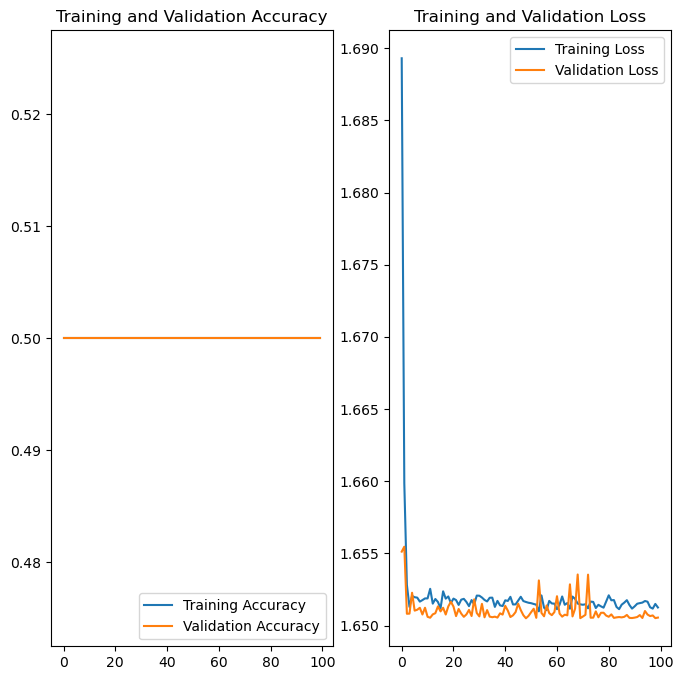

In [21]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(Epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
model.evaluate(X_train,y_train)

150/150 [==============================] - 7s 40ms/step - loss: 1.6505 - accuracy: 0.5000


[1.6505497694015503, 0.5]

In [23]:
model.evaluate(X_val,y_val)

38/38 [==============================] - 1s 23ms/step - loss: 1.6505 - accuracy: 0.5000


[1.6505496501922607, 0.5]